In [4]:
import numpy as np
import pandas as pd
import random

lambda_val = 0.01

# split the data into train and test
def split_data(data: list, split_ratio : float=0.8):
    train_size = int(len(data) * split_ratio)
    random.shuffle(data)
    return data[:train_size], data[train_size:]
# Initialize weights and biases
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)  # For reproducibility
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    # Hidden layer: Z1 = X.W1 + b1, A1 = ReLU(Z1)
    linear_l1 = np.dot(X, W1) + b1
    relu_res = np.maximum(0, linear_l1)  # ReLU activation

    # Output layer: Z2 = A1.W2 + b2, A2 = softmax(Z2)
    linear_l2 = np.dot(relu_res, W2) + b2
    y = softmax(linear_l2)
    
    return linear_l1, relu_res, linear_l2, y

# Softmax function (numerically stable)
def softmax(Z):
    # print("Z max:", np.max(Z), "Z min:", np.min(Z))
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

# Cross-entropy loss
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m  # Add small epsilon for numerical stability
    return loss

def compute_loss_reg(y_true, y_pred, W1, W2, lambda_val=0.01):
    m = y_true.shape[0]
    cross_entropy_loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
    reg_loss = (lambda_val / (2 * m)) * (np.sum(W1**2) + np.sum(W2**2))
    return cross_entropy_loss + reg_loss

# Back propagation
def backward_propagation(X, y_true, Z1, A1, Z2, A2, W1, W2):
    m = X.shape[0]

    # Output layer gradients
    dZ2 = A2 - y_true
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Hidden layer gradients
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (Z1 > 0)  # Derivative of ReLU
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    dW1 += (lambda_val / m) * W1
    dW2 += (lambda_val / m) * W2

    return dW1, db1, dW2, db2

def clip_gradients(gradients, threshold):
    for grad in gradients:
        np.clip(grad, -threshold, threshold, out=grad)
# Gradient descent update
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    clip_gradients([dW1, db1, dW2, db2], threshold=1.0)
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# Training loop
def train_neural_network(X_train, y_train, hidden_size, learning_rate, epochs, output_size):
    input_size = X_train.shape[1]
    
    # Initialize parameters
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

    for epoch in range(epochs):
        # Forward propagation
        Z1, A1, Z2, A2 = forward_propagation(X_train, W1, b1, W2, b2)

        # Compute loss
        loss = compute_loss_reg(y_train, A2, W1, W2)

        # Backward propagation
        dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, Z1, A1, Z2, A2, W1, W2)

        # Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Print loss every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return W1, b1, W2, b2

def one_hot_encode(y, num_classes):
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    one_hot[np.arange(m), y] = 1
    return one_hot


def train_neural_network_with_batches(X_train_batches, y_train_batches, hidden_size, learning_rate, epochs, output_size):
    input_size = X_train_batches.shape[2]
    batches_len = X_train_batches.shape[0]
    # Initialize parameters
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)
    losses = []
    for epoch in range(epochs):
        total_loss = 0  # Initialize total loss for the epoch

        for batch in range(batches_len):
            X_train = X_train_batches[batch]
            y_train = y_train_batches[batch]
            # Forward propagation
            Z1, A1, Z2, A2 = forward_propagation(X_train, W1, b1, W2, b2)

            # Compute loss
            loss = compute_loss(y_train, A2)
            total_loss += loss
            # Backward propagation
            dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, Z1, A1, Z2, A2, W1, W2)

            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
            # print("Z2 max:", np.max(Z2), "Z2 min:", np.min(Z2))
            # print("W1 max:", np.max(W1), "W1 min:", np.min(W1))

            # Print loss every 10 epochs
        losses.append(total_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
    return W1, b1, W2, b2, losses

def get_x_and_labels(data: list[dict]):
    labels = []
    X = []
    for row in data:
        labels.append(row['label'])
        del row['label'] 
        X.append(list(row.values()))
    return X, labels

def split_to_batches(X, y, batch_size):
    X_batches = np.array_split(X, batch_size)
    y_batches = np.array_split(y, batch_size)
    return X_batches, y_batches

def normalize(X):
    X = np.array(X)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return X

In [5]:
df = pd.read_csv('train.csv')

df.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,2,...,0,0,0,6,217,220,141,0,0,0


In [6]:
len(df)

56000

In [7]:

data = df.to_dict(orient='records')
train_data, test_data = split_data(data)
X_train , y_train = get_x_and_labels(train_data)
X_test , y_test = get_x_and_labels(test_data)


In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = normalize(X_train)
X_test = normalize(X_test)



In [9]:
batch_size = 128
learning_rate = 0.01
hidden_size = 128
epochs = 1_000
output_size = 10  # Number of classes

X_train_batches , y_train_batches = split_to_batches(X_train, y_train, batch_size)

In [10]:
X_train_batches = np.array(X_train_batches)
X_train_batches.shape

(128, 350, 784)

In [11]:
y_train_batches = np.array(y_train_batches)
# Apply one-hot encoding to each batch
y_train_batches_one_hot = np.array([one_hot_encode(batch, output_size) for batch in y_train_batches])
y_train_batches.shape, y_train_batches_one_hot.shape

((128, 350), (128, 350, 10))

In [12]:
W1, b1, W2, b2, losses = train_neural_network_with_batches(X_train_batches, y_train_batches_one_hot, hidden_size=hidden_size, learning_rate=learning_rate, epochs=epochs, output_size=10)
# np.array_split(np.array([0 , 1 , 2 , 3 , 4 , 5]), 2)

Epoch 0, Loss: 132.3870
Epoch 10, Loss: 54.3318
Epoch 20, Loss: 47.9059
Epoch 30, Loss: 44.2393
Epoch 40, Loss: 41.5821
Epoch 50, Loss: 39.4695
Epoch 60, Loss: 37.6768
Epoch 70, Loss: 36.1013
Epoch 80, Loss: 34.6939
Epoch 90, Loss: 33.4151
Epoch 100, Loss: 32.2428
Epoch 110, Loss: 31.1531
Epoch 120, Loss: 30.1317
Epoch 130, Loss: 29.1721
Epoch 140, Loss: 28.2647
Epoch 150, Loss: 27.4044
Epoch 160, Loss: 26.5844
Epoch 170, Loss: 25.7978
Epoch 180, Loss: 25.0420
Epoch 190, Loss: 24.3175
Epoch 200, Loss: 23.6230
Epoch 210, Loss: 22.9532
Epoch 220, Loss: 22.3081
Epoch 230, Loss: 21.6850
Epoch 240, Loss: 21.0832
Epoch 250, Loss: 20.5021
Epoch 260, Loss: 19.9409
Epoch 270, Loss: 19.3970
Epoch 280, Loss: 18.8700
Epoch 290, Loss: 18.3580
Epoch 300, Loss: 17.8608
Epoch 310, Loss: 17.3766
Epoch 320, Loss: 16.9076
Epoch 330, Loss: 16.4517
Epoch 340, Loss: 16.0103
Epoch 350, Loss: 15.5814
Epoch 360, Loss: 15.1673
Epoch 370, Loss: 14.7666
Epoch 380, Loss: 14.3796
Epoch 390, Loss: 14.0033
Epoch 400,

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x  # CrossEntropyLoss expects raw logits (no softmax applied here)

# Training function
def train_nn(model, dataloader, loss_fn, optimizer, epochs):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            # Forward pass
            logits = model(batch_X)
            loss = loss_fn(logits, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        losses.append(total_loss)
        # Print epoch loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
    return losses

# Evaluation function
def evaluate_nn(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            logits = model(batch_X)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)
    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

# Generate PyTorch Dataset and DataLoader
def prepare_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)  # Long for CrossEntropyLoss
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Set parameters
input_size = 784  # 28x28 images flattened

# Model, Loss, Optimizer
model = SimpleNN(input_size, hidden_size, output_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Assuming X_train and y_train are your training data (features and labels)
# Prepare PyTorch DataLoader
train_dataloader = prepare_dataloader(X_train, y_train, batch_size)
test_dataloader = prepare_dataloader(X_test, y_test, batch_size=batch_size)

# Train the model
losses_nn = train_nn(model, train_dataloader, loss_fn, optimizer, epochs)

# Evaluate the model
evaluate_nn(model, test_dataloader)


Epoch 0, Loss: 345.3107
Epoch 10, Loss: 131.7007
Epoch 20, Loss: 114.5036
Epoch 30, Loss: 103.5163
Epoch 40, Loss: 94.5396
Epoch 50, Loss: 87.1034
Epoch 60, Loss: 80.3993
Epoch 70, Loss: 74.5493
Epoch 80, Loss: 69.0920
Epoch 90, Loss: 64.2377
Epoch 100, Loss: 59.7006
Epoch 110, Loss: 55.6273
Epoch 120, Loss: 51.7581
Epoch 130, Loss: 48.2209
Epoch 140, Loss: 45.1927
Epoch 150, Loss: 42.2669
Epoch 160, Loss: 39.3442
Epoch 170, Loss: 36.7864
Epoch 180, Loss: 34.4232
Epoch 190, Loss: 32.2309
Epoch 200, Loss: 29.9218
Epoch 210, Loss: 28.1000
Epoch 220, Loss: 26.3166
Epoch 230, Loss: 24.6036
Epoch 240, Loss: 23.0711
Epoch 250, Loss: 21.7440
Epoch 260, Loss: 20.3537
Epoch 270, Loss: 19.1570
Epoch 280, Loss: 17.9703
Epoch 290, Loss: 16.9781
Epoch 300, Loss: 15.8866
Epoch 310, Loss: 14.9784
Epoch 320, Loss: 14.1424
Epoch 330, Loss: 13.2702
Epoch 340, Loss: 12.5295
Epoch 350, Loss: 11.8320
Epoch 360, Loss: 11.1343
Epoch 370, Loss: 10.5486
Epoch 380, Loss: 9.9899
Epoch 390, Loss: 9.5360
Epoch 400

89.19642857142858

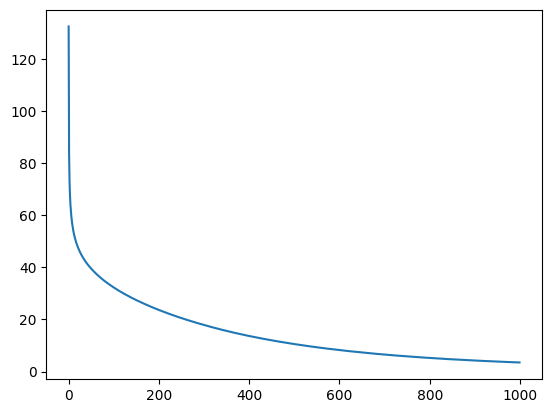

In [14]:
import matplotlib.pyplot as plt 

plt.plot(losses, label='Custom NN')